In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

# Input Parameters

#Geometric Characterisitics

In [2]:
def PCE_Table(Table):
    if Table == 'Indo_HCM':
        PCE_Table1 = pd.DataFrame([['TW' , 0.4 , 0.16], ['Auto' , 0.5 , 0.21], ['Car' , 1.0 , 0], ['LCV' , 1.1 , 0.05], ['HCV' , 1.6 , 0.16], 
                                  ['Bus' , 1.6 , 0.35], ['Bicycle' , 0.3 , 0.14], ['Cycle rickshaw' , 1.8 , 0], ['cart' , 4.0 , 0]], columns = ['Type', 'PCE' , 'SD'])
    else:
        PCE_Table1 = Table
    return (PCE_Table1)

# Design Flow Rate

In [3]:
def Design_Volume(Hourly_vol, Peak_fifteen_min_vol, PHF):
    if PHF == None:
        Design_Volume1 = Peak_fifteen_min_vol * 4
    if PHF != None:
        Design_Volume1 = Hourly_vol / PHF
    return (Design_Volume1)

# Passenger Car Equivalent (PCE)

In [4]:
def PCE(Vol, PCE_Table1, Type_of_veh,  Dev):
    Table = PCE_Table(PCE_Table1)
    print(Table)
    PCU = float(Table.loc[Table['Type'] == Type_of_veh]['PCE'])
    try:
        PCU_std = Dev * float(Table.loc[Table['Type'] == Type_of_veh]['SD'])
    except: 
        PCU_std = 0
        pass
    PCU = PCU + PCU_std
    Vol1 = Vol* PCU
    return(Vol1)

# Base Saturation Flow

In [5]:
def Base_Saturation_Flow(width):
    if width <=0:
        BSF =False
        print('Enter correct width')
    elif width < 7:
        BSF = 630
    elif width <= 10.5:
        BSF = 1140 - 60 * width
    else:
        BSF = 500
    return(BSF)
    

# Adjustment Factor for Bus blockage

In [6]:
def Adjustment_factor_Bus_Blockage(width, ABT , NB, dfs):
    if dfs <= 75:
        fbb = (width - 3 * (ABT * NB) / 3600) / width
    elif dfs > 75:
        fbb = 1
    return(fbb)

# Adjustment factor for Standing Right turning vehicles

In [7]:
def Adjustment_factor_SRTV(width, width_right, exclusive_lane, right_turn_obstruction):
    if right_turn_obstruction == False:
        fbr = 1
    else:
        if width_right == 0:
            width_right = 2.5
        if width >= 7: 
            if exclusive_lane == 0:
                fbr = (width - width_right)/width
            if exclusive_lane > 0:
                fbr = 1
        if width < 7:
            fbr = 1
    return (fbr)

# Adjustment Factor for the Initial Surge of Vehicles

In [8]:
def Adjustment_factor_Surge(effective_green, surge_duration, surge_ratio, anticipation, flare):
    if anticipation == True and flare == False:
        fis = 1
    elif anticipation == True and flare == True:
        fis = (effective_green + (surge_duration * surge_ratio )) /effective_green 
    elif anticipation == False and flare == True:
        fis = 1 + ((surge_ratio)-1 ) *surge_duration / effective_green
    return (fis)

# Calculating adjusted Saturation Flow

In [9]:
def sat_flow(width, fbb, fbr, fis):
    sat_flow = Base_Saturation_Flow(width) *width * fbb * fbr * fis
    return (sat_flow)

# Capacity of a movement group

In [10]:
def capacity_movement_group(Sat_flow , eff_green , Cy_Time):
    capacity_MG = Sat_flow *  eff_green / Cy_Time
    return (capacity_MG)

# Volume to Capacity Ratio 

In [11]:
def v_by_c(vol_MG , Sat_flow , eff_green , Cy_Time):
    v_by_c = vol_MG * Cy_Time/ (Sat_flow * eff_green) 
    return (v_by_c)

# Critical Volume to Capacity Ratio of the Intersection

In [12]:
def critical_v_by_c(n_phase, vol_MG_list , Sat_flow_list , Cy_Time, L):
    X = 0
    for i in range(n_phase):
        X = X + (vol_MG_list[i]/Sat_flow_list[i]) * (Cy_Time/ (Cy_Time - L))
    return (X)

# Uniform Delay (d1)

In [13]:
def Uniform_delay(C, green, X):
    d1 = 0.50 * C * (1- green/C)* (1- green/C)/(1-min(1,X) *green/C)
    return (d1)

# Incremental delay (d2)

In [14]:
def incremental_delay(X, T, CSI):
    d2 = 900 * T * (X-1 + math.sqrt((X-1) * (X-1) + 4 * X / (CSI * T)))
    return (d2)

# Initial Queue delay (d3)

In [15]:
def delay_initial_queue( X,  T, CSI, Qb , C):
    if Qb ==0:
        t = 0
    elif Qb != 0:
        t = min(T, Qb/(CSI * (1 - min(1 , X))))
    if t <= T:
        u = 0
    elif t == T:
        u = 1- C*T/(Qb * (1- min(1,X)))
    if Qb == 0:
        d3 = 0
    elif Qb!= 0:
        d3 = 1800 * Qb * (1+u) * t / (CSI * T)
    return (d3)

# Total Approach delay

In [16]:
def approach_delay(V, C, green, X, T, CSI, Qb):
    d1 = Uniform_delay(C, green, X)
    d2 = incremental_delay(X, T, CSI)
    d3 = delay_initial_queue( X,  T, CSI, Qb , C)
    d = V * (0.9 * d1+d2+d3)
    return (d)

# Total Intersection Delay

In [17]:
def intersection_delay(n_phase, list_of_volume , C, list_of_X, T, list_of_greens, CSI, list_of_Qb):
    intersection_delay = 0
    total_veh = 0
    for i in range(n_phase):
        intersection_delay = intersection_delay + approach_delay(list_of_volume[i], C, list_of_greens[i], list_of_X[i], T, CSI, list_of_Qb[i])
        total_veh = total_veh + list_of_volume[i]
    average_delay = intersection_delay / total_veh
    return (intersection_delay, average_delay)

# Level of Service (Control Delay)

In [18]:
def LOS_CD(average_delay):
    if average_delay <= 20:
        LOS = 'A'
    elif average_delay <= 40:
        LOS = 'B'
    elif average_delay <= 65:
        LOS = 'C'
    elif average_delay <= 95:
        LOS = 'D'
    elif average_delay <= 130:
        LOS = 'E'
    else:
        LOS = 'F'
    return (LOS)

# Level of Service (V/C)

In [19]:
def LOS_VC(X):
    if X <= 0.45:
        LOS = 'A'
    elif X <= 0.75:
        LOS = 'B'
    elif X <= 0.95:
        LOS = 'C'
    elif X <= 1.05:
        LOS = 'D'
    elif X <= 1.10:
        LOS = 'E'
    else:
        LOS = 'F'
    return (LOS)

In [20]:
def cap_and_list_of_X(number_of_phases, effective_green_time ,Cycle_Length , approach_widths, Average_Bus_Blockage_Time, 
              Number_of_buses_stopping, distance_of_Bus_stops_from_stopline, right_turning_width,
             Exclusive_right_turning_Lanes, surge_ratio, Presence_of_anticipation, list_of_volume, right_turn_obstruction):
    cap = 0
    list_a = []
    for i in range(number_of_phases):
        BSF = Base_Saturation_Flow(approach_widths[i])
        fbb = Adjustment_factor_Bus_Blockage(approach_widths[i], Average_Bus_Blockage_Time[i] , Number_of_buses_stopping[i], distance_of_Bus_stops_from_stopline[i])
        fbr = Adjustment_factor_SRTV(approach_widths[i], right_turning_width[i], Exclusive_right_turning_Lanes[i], right_turn_obstruction[i])
        fis = Adjustment_factor_Surge(effective_green_time[i], surge_duration[i], surge_ratio[i], 
                                     Presence_of_anticipation[i], Presence_of_flare[i])
        sf = sat_flow( approach_widths[i], fbb, fbr, fis)
        capacity = capacity_movement_group(sf , effective_green_time[i] , Cycle_Length)
        cap = cap + capacity
        vc = v_by_c(list_of_volume[i] , sf , effective_green_time[i] , Cycle_Length)
        list_a.append(vc)
    return (cap, list_a)

# Input_parameters

Geometric
1. width
2. presence/absence of exclusive lanes for exclusive right turn phase
3. Presence/absense of bus bays or curbside bus stops

In [21]:
number_of_phases = 4
approach_widths = [7.5 , 7.5 , 7.5 , 7.5]
Exclusive_right_turning_Lanes = [0,0,0,0]
right_turning_width = [0,0,0,0]
right_turn_obstruction = [False, True, False, False]
Exclusive_right_turn_phase = [0, 0, 0, 0]
Bus_bays = [False, False, True, False]
distance_of_Bus_stops_from_stopline = [75,80,87,90]
Average_Bus_Blockage_Time = [15,15,15,15]

Traffic Characteristics
1. Classified peak hour traffic volume of all movements
2. Mode-wise classification
3. Number of buses stopping at the intersection
4. Presence or absense of approach flare and anticipated early movement and resulting initial surge
5. Initial Queue Length

In [22]:
Peak_hour_volume = [1600,1800,2800,1200]
PHF = [.95, .95 , .95 , .89]
Number_of_buses_stopping = [12,14,15,65]
Distance_of_bus_stops = [60,70,58,96]
Presence_of_flare = [True, True, True, True]
Presence_of_anticipation = [True, True, True, True]
surge_duration = [5,5,5,5]
surge_ratio = [1.15,1.15,1.15,1.15]
Initial_Queue_Length = [0,0,0,0]

Control characteristic:
1. Cycle Time
2. Green Time
3. Change and clearance interval
4. Phase Plan
5. Analysis Period

In [23]:
Maximum_Cycle_Time = 180
Minimum_Phase_Time = [20,20,20,20]
effective_g_int = [20,20,20,20]
Yellow= [3,3,3,3]
All_Red_Time = [2,2,2,2]
Analysis_Period = .25

In [24]:
def Signal_Design(number_of_phases , approach_widths, Exclusive_right_turn_phase, Bus_bays, Peak_hour_volume, PHF, 
                   Number_of_buses_stopping, Distance_of_bus_stops, Presence_of_flare, Presence_of_anticipation,
                   Initial_Queue_Length, Maximum_Cycle_Time, Minimum_Phase_Time, 
                   effective_green_time, Yellow, All_Red_Time, Analysis_Period, Average_Bus_Blockage_Time, 
                  distance_of_Bus_stops_from_stopline, right_turning_width, Exclusive_right_turning_Lanes, surge_ratio, right_turn_obstruction):
    
    
    list_of_Qb = Initial_Queue_Length
    list_of_greens = effective_green_time
    T = Analysis_Period
    Cycle_Length = sum(effective_green_time) + sum(Yellow) + sum(All_Red_Time)
    list_of_volume = list(np.array(Peak_hour_volume) * np.array(PHF))
    CSI , list_of_X = cap_and_list_of_X(number_of_phases, effective_green_time , Cycle_Length , approach_widths, Average_Bus_Blockage_Time, 
              Number_of_buses_stopping, distance_of_Bus_stops_from_stopline, right_turning_width,
             Exclusive_right_turning_Lanes, surge_ratio, Presence_of_anticipation, list_of_volume, right_turn_obstruction)
    idl, average_delay = intersection_delay(number_of_phases, list_of_volume , Cycle_Length, list_of_X, T, list_of_greens, CSI, list_of_Qb)
    los = LOS_CD(average_delay)
    return(average_delay)

In [25]:
a = Signal_Design(number_of_phases , approach_widths, Exclusive_right_turn_phase, Bus_bays, Peak_hour_volume, PHF, 
                    Number_of_buses_stopping, Distance_of_bus_stops, Presence_of_flare, Presence_of_anticipation,
                    Initial_Queue_Length, Maximum_Cycle_Time, Minimum_Phase_Time, 
                    effective_green_time, Yellow, All_Red_Time, Analysis_Period, Average_Bus_Blockage_Time, 
                    distance_of_Bus_stops_from_stopline, right_turning_width, Exclusive_right_turning_Lanes, surge_ratio, right_turn_obstruction)
print(a)

NameError: name 'effective_green_time' is not defined

In [26]:
def Optimum(effective_g):
    return(Signal_Design(number_of_phases , approach_widths, Exclusive_right_turn_phase, Bus_bays, Peak_hour_volume, PHF, 
                         Number_of_buses_stopping, Distance_of_bus_stops, Presence_of_flare, Presence_of_anticipation,
                         Initial_Queue_Length, Maximum_Cycle_Time, Minimum_Phase_Time, 
                         effective_g, Yellow, All_Red_Time, Analysis_Period, Average_Bus_Blockage_Time, 
                         distance_of_Bus_stops_from_stopline, right_turning_width, Exclusive_right_turning_Lanes, surge_ratio, right_turn_obstruction))

# Limited-memory BFGS (L-BFGS or LM-BFGS)

In [27]:
from scipy.optimize import minimize

In [28]:
def constraint_max(effective_g):
    return(Maximum_Cycle_Time -sum(effective_g) - sum(Yellow) - sum(All_Red_Time))

In [29]:
bnds = []
for i in range(number_of_phases):
    bnds.append((Minimum_Phase_Time[i], Maximum_Cycle_Time))

con1 = {'type': 'ineq' , 'fun' : constraint_max}
cons = [con1]

In [30]:
history = []
def callback(x):
    
    fobj = Optimum(x)
    history.append(fobj)
res = minimize(Optimum, effective_g_int, method='L-BFGS-B',
               options={'xatol': 1e-8, 'disp': True}, bounds = bnds, constraints = cons, callback=callback)
res.fun

C:\Users\n10680535\Anaconda3\lib\site-packages\scipy\optimize\_minimize.py:539: RuntimeWarning: Method L-BFGS-B cannot handle constraints.
  RuntimeWarning)
C:\Users\n10680535\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: OptimizeWarning: Unknown solver options: xatol
  import sys


267.3843809727862

In [31]:

print(history)
df = pd.DataFrame(history)
df.columns =  ['L-BFGS-B']

[296.3342159191479, 274.44594157748725, 268.29520500849833, 267.6735581203625, 267.4162669213378, 267.38840695943134, 267.3851624205757, 267.3844693484959, 267.38438306042093, 267.3843810031683, 267.3843809727862]


Text(0, 0.5, 'Control Delay per Vehicle (sec/veh)')

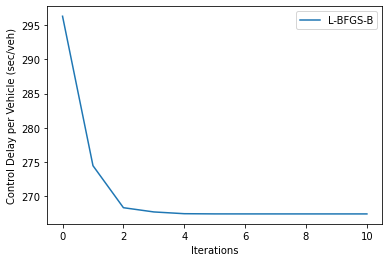

In [32]:
ax = df.plot()
ax.set_xlabel("Iterations")
ax.set_ylabel("Control Delay per Vehicle (sec/veh)")

# Sequential quadratic programming (SQP) algorithm 

In [33]:
history1 = []
def callback1(x):
    
    fobj = Optimum(x)
    history1.append(fobj)
res = minimize(Optimum, effective_g_int, method='SLSQP',
               options={'xatol': 1e-8, 'disp': True}, bounds = bnds, constraints = cons, callback=callback1)
res.fun

Optimization terminated successfully    (Exit mode 0)
            Current function value: 267.38438115521745
            Iterations: 14
            Function evaluations: 70
            Gradient evaluations: 14


C:\Users\n10680535\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: OptimizeWarning: Unknown solver options: xatol
  import sys


267.38438115521745

[296.33418962341517, 276.08291577966423, 268.18879950153024, 267.6980242302781, 267.50109755078904, 267.42854633598046, 267.39581419288703, 267.38636407124346, 267.38468644769006, 267.3844733432046, 267.3844109251359, 267.38438474351096, 267.38438115521745, 267.38438115521745]


Text(0, 0.5, 'Control Delay per Vehicle (sec/veh)')

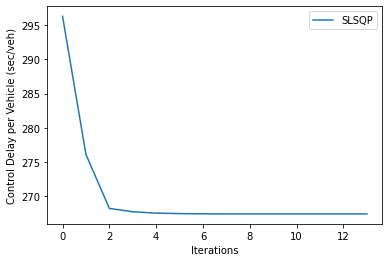

In [34]:
print(history1)
df1 = pd.DataFrame(history1)
df1.columns =  ['SLSQP']
ax1 = df1.plot()
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Control Delay per Vehicle (sec/veh)")

Text(0, 0.5, 'Control Delay per Vehicle (sec/veh)')

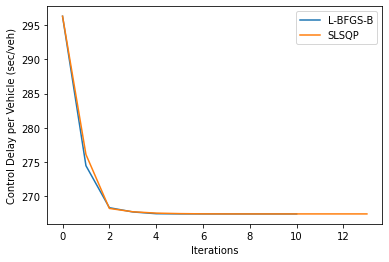

In [35]:
fig,ax = plt.subplots()
df.plot(ax = ax)
df1.plot(ax=ax)
ax.set_xlabel("Iterations")
ax.set_ylabel("Control Delay per Vehicle (sec/veh)")

# Forest Res algorithm

In [36]:
from functools import partial
from skopt.plots import plot_evaluations
from skopt import gp_minimize, forest_minimize, dummy_minimize
from skopt.plots import plot_objective

In [ ]:
bounds = bnds

In [ ]:
n_calls = 200

In [ ]:
forest_res = forest_minimize(Optimum, bounds, n_calls=n_calls,
                             base_estimator="ET", random_state=4)

In [ ]:
forest_res

In [ ]:
_ = plot_evaluations(forest_res, dimensions = ['G1', 'G2', 'G3', 'G4'])
_ = plot_objective(forest_res, n_samples=200, dimensions = ['G1', 'G2', 'G3', 'G4'], size = 3)

# BruteForce

In [ ]:
bnds

In [ ]:
rranges = [slice(20, 180, 5), slice(20, 180, 5), slice(20, 180,5), slice(20, 180,5)]

In [ ]:
rranges

In [ ]:
from scipy import optimize
resbrute = optimize.brute(Optimum, ranges= rranges, full_output=True,
                          finish=None)

In [ ]:
resbrute[0]

In [ ]:
resbrute[1]

In [ ]:
resbrute[3]

# Differential evolution

In [ ]:
from scipy.optimize import rosen, differential_evolution

In [ ]:
bounds = [(20, 180), (20, 180), (20, 180), (20, 180)]

In [ ]:
result = differential_evolution(Optimum, bounds, updating='deferred',
                                workers=2)

In [ ]:
result.x, result.fun